In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, beta
from scipy.optimize import minimize
from numpy.random import dirichlet


In [14]:
sample = "TCGA-44-2655"
method = "byAF"
ID = 1
TPR = 0.95
TNR = 0.9

In [3]:
def binomial_pmf(k, n, p):
    if k > n or k < 0:
        return 0.0
    coeff = 1.0
    for i in range(k):
        coeff *= (n - i) / (i + 1)
    return coeff * (p ** k) * ((1 - p) ** (n - k))

In [11]:
def calculate_probabilities(C_TR, C_TA, C_NR, C_NA, major, minor, totalCN, TiN, AF):
    C_T = C_TA + C_TR
    C_N = C_NA + C_NR
    C = C_T + C_N
    C_A = C_TA + C_NA
    if C == 0: 
        return 0.0, 0.0, 0.0, 0.0, 0.0

    x_T = TiT * totalCN / ((1 - TiT) * 2 + TiT * totalCN)
    y_T = 1 - x_T
    if totalCN == 0:
        x_N = 0
        y_N = 1
    else:
        x_N = TiN * totalCN / ((1 - TiN) * 2 + TiN * totalCN)
        y_N = 1 - x_N
    
    # Calculate likelihoods
    # No mutation:
    P_TA_N = binomial_pmf(C_TA, n=C_T, p=1-TNR)
    P_NA_N = binomial_pmf(C_NA, n=C_N, p=1-TNR)
    P_R_no_mutation = P_TA_N * P_NA_N

    # Homozygous germline:
    P_TA_O = binomial_pmf(C_TA, n=C_T, p=TPR)
    P_NA_O = binomial_pmf(C_NA, n=C_N, p=TPR)
    P_R_homozygous = P_TA_O * P_NA_O

    if totalCN == 0:
        P_TA_E = binomial_pmf(C_TA, n=C_T, p=y_T*(TPR+1-TNR)/2)
        P_NA_E = binomial_pmf(C_NA, n=C_N, p=y_N*(TPR+1-TNR)/2)
        P_R_heterozygous = P_TA_E * P_NA_E

        P_TA_C = binomial_pmf(C_TA, n=C_T, p=y_T*(1-TNR))
        P_NA_C = binomial_pmf(C_NA, n=C_N, p=y_N*(1-TNR))
        P_R_clonal = P_TA_C * P_NA_C

    else:
        # Heterozygous germline:
        p_T_minor = TPR*(y_T/2+x_T*minor/totalCN)+(1-TNR)*(y_T/2+x_T*major/totalCN)
        p_T_major = TPR*(y_T/2+x_T*major/totalCN)+(1-TNR)*(y_T/2+x_T*minor/totalCN)
        p_N_minor = TPR*(y_N/2+x_N*minor/totalCN)+(1-TNR)*(y_N/2+x_N*major/totalCN)
        p_N_major = TPR*(y_N/2+x_N*major/totalCN)+(1-TNR)*(y_N/2+x_N*minor/totalCN)
        P_TA_E = binomial_pmf(C_TA, n=C_T, p=p_T_minor)/2 + binomial_pmf(C_TA, n=C_T, p=p_T_major)/2
        P_NA_E = binomial_pmf(C_NA, n=C_N, p=p_N_minor)/2 + binomial_pmf(C_NA, n=C_N, p=p_N_major)/2
        P_R_heterozygous = P_TA_E * P_NA_E

        # Clonal: 
        P_TA_C, P_NA_C = 0, 0
        multiplicity = np.arange(1, major + 1)
        for i in multiplicity:
            p_TA_C = x_T*(TPR*i/totalCN+(1-TNR)*(totalCN-i)/totalCN)+y_T*(1-TNR)
            p_NA_C = x_N*(TPR*i/totalCN+(1-TNR)*(totalCN-i)/totalCN)+y_N*(1-TNR)
            P_TA_C += binomial_pmf(C_TA, n=C_T, p=p_TA_C)/major
            P_NA_C += binomial_pmf(C_NA, n=C_N, p=p_NA_C)/major
        P_R_clonal = P_TA_C * P_NA_C

    # Combine the probabilities
    # set prior probabilities
    if method == "uniform":
        p_clonal = 0.25
        p_homozygous = 0.25
        p_heterozygous = 0.25
        p_no_mutation = 0.25
    elif method == "byAF":
        p_clonal = 0.0001
        p_germline = 1-p_clonal
        p_homozygous = AF*AF*p_germline
        p_heterozygous = 2*AF*(1-AF)*p_germline
        p_no_mutation = (1-AF)*(1-AF)*p_germline

    #P_no_mutation = P_R_no_mutation * p_no_mutation + 1e-06
    #P_homozygous = P_R_homozygous * p_homozygous + 1e-06
    #P_heterozygous = P_R_heterozygous * p_heterozygous + 1e-06
    #P_clonal = P_R_clonal * p_clonal + 1e-06
    #P_R = (P_no_mutation + P_homozygous + P_heterozygous + P_clonal)
    log_P_no_mutation = safe_log(P_R_no_mutation * p_no_mutation)
    log_P_homozygous = safe_log(P_R_homozygous * p_homozygous)
    log_P_heterozygous = safe_log(P_R_heterozygous * p_heterozygous)
    log_P_clonal = safe_log(P_R_clonal * p_clonal)
    log_P_R = np.logaddexp(
        np.logaddexp(log_P_no_mutation, log_P_homozygous),
        np.logaddexp(log_P_heterozygous, log_P_clonal)
    )
    #print(P_no_mutation/P_R, P_homozygous/P_R, P_heterozygous/P_R, P_clonal/P_R)
    #print(C_TR, C_TA, C_NR, C_NA, major, minor)
    #print(P_R_no_mutation, P_R_homozygous, P_R_heterozygous, P_R_clonal)
    #print(P_R)
    return log_P_no_mutation, log_P_homozygous, log_P_heterozygous, log_P_clonal, log_P_R
    #return -np.log(P_R)

In [10]:
THRESHOLD = 1e-300
def safe_log(prob):
    """Return log(prob) if prob > THRESHOLD, else -inf."""
    return np.log(prob) if prob > THRESHOLD else 0

In [74]:
def prob_sum(TiN, data):
    log_P_e = 0
    log_P_c = 0
    log_P = 0
    for i in range(data.shape[0]):
        row = data[i]
        log_P_e += calculate_probabilities(
            row[0], row[1], row[2], row[3],
            row[4], row[5], row[6], TiN, row[7]
        )[0]
        log_P_c += calculate_probabilities(
            row[0], row[1], row[2], row[3],
            row[4], row[5], row[6], TiN, row[7]
        )[1]
        log_P += calculate_probabilities(
            row[0], row[1], row[2], row[3],
            row[4], row[5], row[6], TiN, row[7]
        )[2]
    return log_P_e, log_P_c, log_P

In [12]:
C_TR, C_TA, C_NR, C_NA = 120, 0, 32, 0
major, minor = 2, 1
totalCN = major + minor
TiT = 0.27
TiN = 0.1
AF = 0.0001

print(calculate_probabilities(C_TR, C_TA, C_NR, C_NA, major, minor, totalCN, TiN, AF))

(-16.015098394990595, -473.77208632915915, -109.52438788084676, -42.189622215461895, -16.015098394986303)


In [70]:
data = pd.read_csv(
    #"/rsrch6/home/genetics/vanloolab/secure/TCGA/LUAD_WGS_BAM/TCGA-44-2655/partitioned/AFcombined/filtered_final.txt",
    f"/rsrch8/home/genetics/tchu/TCGA_LUAD/step6_estimate/subsamples/{sample}/random_sample{ID}.txt", 
    sep = "\t", header = 0, 
dtype={'chr': int, 'position': int, 'major': int, 'minor': int, 'totalCN': int, 'tumor_ref': int, 'tumor_alt': int, 'normal_ref': int, 'normal_alt': int, 'AF': float},
index_col=False)
structured_array = data[['tumor_ref', 'tumor_alt', 'normal_ref', 'normal_alt', 'major', 'minor', 'totalCN', 'AF']].to_records(index=False)

In [13]:
P_n = [-3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484]
P_o = [-3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484, -3556606.862084484]
P_e = [-47792449.91234423, -47726792.93617015, -47626876.13578049, -47527959.03195893, -47431679.13206569, -47336638.500328384, -47241281.47616033, -47144132.431473576, -47043821.87486387, -46939755.039565735]
P_c = [-15376414.709273182, -15976981.324202286, -16607571.174267925, -17277070.123495013, -17996092.85551285, -18777325.420222547, -19639809.403065417, -20617957.53364555, -21792776.298070736, -23515577.022196785]
logP = [-3343916.072335108, -3343791.4091637707, -3343734.62515076, -3343721.7850551526, -3343741.74567187, -3343790.4979034048, -3343871.9182834956, -3343996.3823061655, -3344196.9273145148, -3344577.0655866154]

In [64]:
P_n = [-3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889]
P_o = [-3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889, -3558444.956445889]
P_e = [-47796853.71437524, -47731192.375406824, -47631268.06814221, -47532343.14191143, -47436055.32777799, -47341006.63439101, -47245641.32285868, -47148483.694245964, -47048164.22735327, -46944088.34781565]
P_c = [-15376414.709273182, -15976981.324202286, -16607571.174267925, -17277070.123495013, -17996092.85551285, -18777325.420222547, -19639809.403065417, -20617957.53364555, -21792776.298070736, -23515577.022196785]
logP = [-3344301.6956045446, -3344177.0330564105, -3344120.249241668, -3344107.409205293, -3344127.3698385092, -3344176.122074293, -3344257.5424553854, -3344382.0064782705, -3344582.5514866603, -3344962.6897587674]

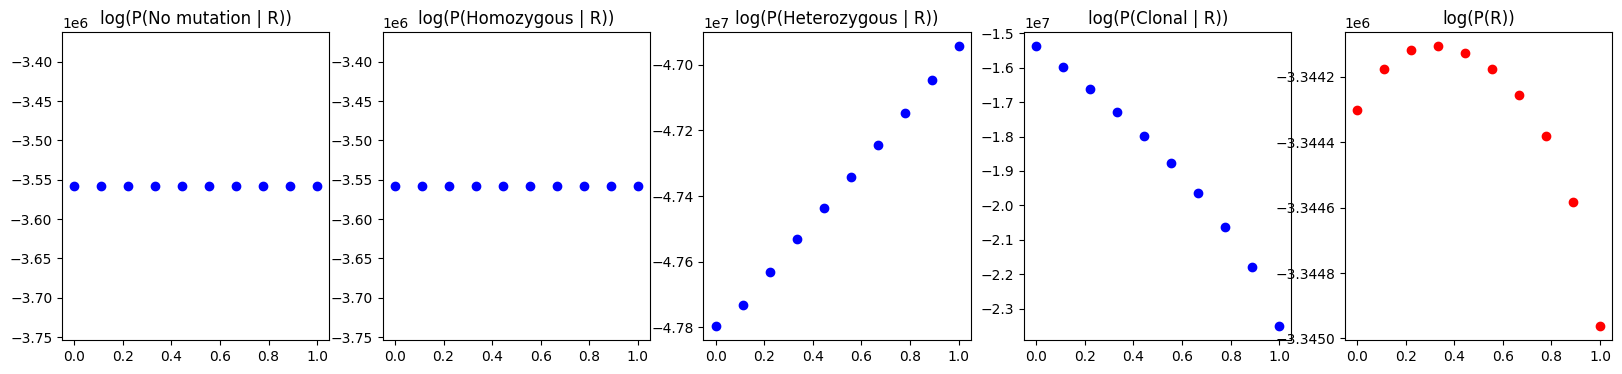

In [65]:
import matplotlib.pyplot as plt
TiN = np.linspace(0, 1, 10)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Plot individual estimations as scatter points
axes[0].scatter(TiN, P_n, color='blue', label='Estimations (Uniform)', zorder=3)
axes[0].set_title('log(P(No mutation | R))')
axes[1].scatter(TiN, P_o, color='blue', label='Estimations (Uniform)', zorder=3)
axes[1].set_title('log(P(Homozygous | R))')
axes[2].scatter(TiN, P_e, color='blue', label='Estimations (Uniform)', zorder=3)
axes[2].set_title('log(P(Heterozygous | R))')
axes[2].ticklabel_format(useOffset=False, axis='y')
axes[3].scatter(TiN, P_c, color='blue', label='Estimations (Uniform)', zorder=3)
axes[3].set_title('log(P(Clonal | R))')
axes[4].scatter(TiN, logP, color='red', label='Estimations (Uniform)', zorder=3)
axes[4].set_title('log(P(R))')
axes[4].ticklabel_format(useOffset=False, axis='y')

## Plot results

In [3]:
def log_binomial_pmf(n, k, p):
    if p == 0 and k > 0:
        return -np.inf  # log(0) for impossible events
    if p == 1 and k < n:
        return -np.inf  # log(0) for impossible events
    log_binom_coeff = loggamma(n + 1) - loggamma(k + 1) - loggamma(n - k + 1)
    log_prob = k * np.log(p) + (n - k) * np.log(1 - p)
    
    return log_binom_coeff + log_prob

In [2]:
def logaddexp_reduce(values):
    """Manually implement logaddexp.reduce for Numba."""
    result = values[0]
    for i in range(1, len(values)):
        result = np.logaddexp(result, values[i])
    return result

def factorial(n):
    if n < 0:
        return 1  # Gracefully handle negative inputs
    if n == 0 or n == 1:
        return 1
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

def n_choose_k(n, k):
    if k > n or k < 0:
        return 0  # Invalid cases
    denom = factorial(k) * factorial(n - k)
    if denom == 0:
        return 0  # Avoid division by zero
    return factorial(n) // denom

def log_binomial_pmf(k, n, p):
    if k < 0 or k > n or p <= 0 or p >= 1:
        return -np.inf  # Invalid inputs lead to log(0)
    n_ck = n_choose_k(n, k)
    if n_ck == 0:
        return -np.inf  # Handle invalid binomial coefficient
    log_prob = np.log(n_ck) + k * np.log(p) + (n - k) * np.log(1 - p)
    return log_prob

In [ ]:
P_TA_N = log_binomial_pmf(0, n=120, p=1-TNR)
P_NA_N = log_binomial_pmf(0, n=25, p=1-TNR)
P_R_no_mutation = P_TA_N + P_NA_N  

In [6]:
P_R_no_mutation

-15.27727477038481

In [45]:
def calculate_probabilities(C_TR, C_TA, C_NR, C_NA, major, minor, totalCN, AF, TiN):
    C_T = C_TA + C_TR
    C_N = C_NA + C_NR
    C = C_T + C_N
    C_A = C_TA + C_NA
    if C == 0: 
        return 0.0, 0.0, 0.0, 0.0, 0.0

    if AF <= 0.0001:
        AF = 0.0001
    elif AF >= 0.9999:
        AF = 0.9999

    x_T = TiT * totalCN / ((1 - TiT) * 2 + TiT * totalCN)
    y_T = 1 - x_T
    if totalCN == 0:
        x_N = 0
        y_N = 1
    else:
        x_N = TiN * totalCN / ((1 - TiN) * 2 + TiN * totalCN)
        y_N = 1 - x_N

    # Calculate likelihoods
    # No mutation:
    P_TA_N = log_binomial_pmf(C_TA, n=C_T, p=1-TNR)
    P_NA_N = log_binomial_pmf(C_NA, n=C_N, p=1-TNR)
    P_R_no_mutation = P_TA_N + P_NA_N

    # Homozygous germline:
    P_TA_O = log_binomial_pmf(C_TA, n=C_T, p=TPR)
    P_NA_O = log_binomial_pmf(C_NA, n=C_N, p=TPR)
    P_R_homozygous = P_TA_O + P_NA_O

    if totalCN == 0:
        P_TA_E = log_binomial_pmf(C_TA, n=C_T, p=(TPR+1-TNR)/2)
        P_NA_E = log_binomial_pmf(C_NA, n=C_N, p=(TPR+1-TNR)/2)
        P_R_heterozygous = P_TA_E + P_NA_E

        P_TA_C = log_binomial_pmf(C_TA, n=C_T, p=(1-TNR))
        P_NA_C = log_binomial_pmf(C_NA, n=C_N, p=(1-TNR))
        P_R_clonal = P_TA_C + P_NA_C
    else:
        # Heterozygous germline:
        p_T_minor = TPR*(y_T/2+x_T*minor/totalCN)+(1-TNR)*(y_T/2+x_T*major/totalCN)
        p_T_major = TPR*(y_T/2+x_T*major/totalCN)+(1-TNR)*(y_T/2+x_T*minor/totalCN)
        p_N_minor = TPR*(y_N/2+x_N*minor/totalCN)+(1-TNR)*(y_N/2+x_N*major/totalCN)
        p_N_major = TPR*(y_N/2+x_N*major/totalCN)+(1-TNR)*(y_N/2+x_N*minor/totalCN)
        P_TA_E = np.logaddexp(
            log_binomial_pmf(C_TA, n=C_T, p=p_T_minor) - np.log(2), 
            log_binomial_pmf(C_TA, n=C_T, p=p_T_major) - np.log(2)
            )
        P_NA_E = np.logaddexp(
            log_binomial_pmf(C_NA, n=C_N, p=p_N_minor) - np.log(2), 
            log_binomial_pmf(C_NA, n=C_N, p=p_N_major) - np.log(2)
            )
        P_R_heterozygous = P_TA_E + P_NA_E
        # Clonal: 
        #P_TA_C, P_NA_C = 0, 0
        multiplicity = range(1, major + 1)        
        p_TA_C = [TPR*(x_T*i/totalCN) + (1-TNR)*(y_T+x_T*(totalCN-i)/totalCN) for i in multiplicity]
        p_NA_C = [TPR*(x_N*i/totalCN) + (1-TNR)*(y_N+x_N*(totalCN-i)/totalCN) for i in multiplicity]
        log_binoms_T = [log_binomial_pmf(C_TA, n=C_T, p=P) for P in p_TA_C]
        log_binoms_N = [log_binomial_pmf(C_NA, n=C_N, p=P) for P in p_NA_C]
        P_TA_C = logaddexp_reduce(log_binoms_T) - np.log(major)
        P_NA_C = logaddexp_reduce(log_binoms_N) - np.log(major)

        #for i in multiplicity:
            #p_TA_C = TPR*(x_T*i/totalCN) + (1-TNR)*(y_T+x_T*(totalCN-i)/totalCN)
            #p_NA_C = TPR*(x_N*i/totalCN) + (1-TNR)*(y_N+x_N*(totalCN-i)/totalCN)
            #P_TA_C += binomial_pmf(C_TA, n=C_T, p=p_TA_C)/major
            #P_NA_C += binomial_pmf(C_NA, n=C_N, p=p_NA_C)/major
        P_R_clonal = P_TA_C + P_NA_C

    # Combine the probabilities
    # set prior probabilities
    if method == "uniform":
        p_clonal = 0.25
        p_homozygous = 0.25
        p_heterozygous = 0.25
        p_no_mutation = 0.25
    elif method == "byAF":
        p_clonal = 0.0001
        p_germline = 1-p_clonal
        p_homozygous = AF*AF*p_germline
        p_heterozygous = 2*AF*(1-AF)*p_germline
        p_no_mutation = (1-AF)*(1-AF)*p_germline

    log_P_no_mutation = P_R_no_mutation + np.log(p_no_mutation)
    log_P_homozygous = P_R_homozygous + np.log(p_homozygous)
    log_P_heterozygous = P_R_heterozygous + np.log(p_heterozygous)
    log_P_clonal = P_R_clonal + np.log(p_clonal)

    log_P_R = logaddexp_reduce([log_P_no_mutation, log_P_homozygous, log_P_heterozygous, log_P_clonal])

    return log_P_no_mutation, log_P_homozygous, log_P_heterozygous, log_P_clonal, log_P_R


In [10]:
method = "byAF"

In [57]:
def prob_sum(TiN, data):
    log_P_n, log_P_o, log_P_e, log_P_c, log_P = 0, 0, 0, 0, 0
    for i in range(data.shape[0]):
        row = data[i]
        log_results = calculate_probabilities(
            row[0], row[1], row[2], row[3],
            row[4], row[5], row[6], row[7], TiN
        )
        print(log_results)
        log_P_n += log_results[0]
        log_P_o += log_results[1]
        log_P_e += log_results[2]
        log_P_c += log_results[3]
        log_P += log_results[4]
    return log_P_n, log_P_o, log_P_e, log_P_c, log_P

In [49]:
data = pd.read_csv(
    #"/rsrch6/home/genetics/vanloolab/secure/TCGA/LUAD_WGS_BAM/TCGA-44-2655/partitioned/AFcombined/filtered_final.txt",
    f"/rsrch8/home/genetics/tchu/TCGA_LUAD/step6_estimate/subsamples/{sample}/random_sample{ID}.txt", 
    sep = "\t", header = 0, 
dtype={'chr': int, 'position': int, 'major': int, 'minor': int, 'totalCN': int, 'tumor_ref': int, 'tumor_alt': int, 'normal_ref': int, 'normal_alt': int, 'AF': float},
index_col=False)
data_array = data.head(2)[['tumor_ref', 'tumor_alt', 'normal_ref', 'normal_alt', 'major', 'minor', 'totalCN', 'AF']].to_records(index=False)


In [56]:
data_array

rec.array([(120, 0, 25, 0, 1, 1, 2, 0.0001),
           (110, 0, 20, 0, 1, 1, 2, 0.0001)],
          dtype=[('tumor_ref', '<i8'), ('tumor_alt', '<i8'), ('normal_ref', '<i8'), ('normal_alt', '<i8'), ('major', '<i8'), ('minor', '<i8'), ('totalCN', '<i8'), ('AF', '<f8')])

## Reset

In [62]:
import numpy as np
import pandas as pd
# from numba import njit
import sys


In [63]:
sample = "TCGA-44-2655"
ID = 1
method = "byAF"

TPR = 0.9  # alternate and seq'd as alternate
TNR = 0.95  # reference and seq'd as reference
if sample == "TCGA-44-2655":
    TiT = 0.27
elif sample == "TCGA-50-6592":
    TiT = 0.22
elif sample == "TCGA-55-6986":
    TiT = 0.40

def logaddexp_reduce(values):
    """Manually implement logaddexp.reduce for Numba."""
    result = values[0]
    for i in range(1, len(values)):
        result = np.logaddexp(result, values[i])
    return result

def factorial(n):
    if n < 0:
        return 1  # Gracefully handle negative inputs
    if n == 0 or n == 1:
        return 1
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

def n_choose_k(n, k):
    if k > n or k < 0:
        return 0  # Invalid cases
    denom = factorial(k) * factorial(n - k)
    if denom == 0:
        return 0  # Avoid division by zero
    return factorial(n) // denom

def log_binomial_pmf(k, n, p):
    if k < 0 or k > n or p <= 0 or p >= 1:
        print(k, n)
        return -np.inf  # Invalid inputs lead to log(0)
    n_ck = n_choose_k(n, k)
    if n_ck == 0:
        return -np.inf  # Handle invalid binomial coefficient
    log_prob = np.log(n_ck) + k * np.log(p) + (n - k) * np.log(1 - p)
    return log_prob


In [ ]:
def calculate_probabilities(C_TR, C_TA, C_NR, C_NA, major, minor, totalCN, AF, TiN):
    C_T = C_TA + C_TR
    C_N = C_NA + C_NR
    C = C_T + C_N
    C_A = C_TA + C_NA
    if C == 0: 
        return 0.0, 0.0, 0.0, 0.0, 0.0

    if AF <= 0.0001:
        AF = 0.0001
    elif AF >= 0.9999:
        AF = 0.9999

    x_T = TiT * totalCN / ((1 - TiT) * 2 + TiT * totalCN)
    y_T = 1 - x_T
    if totalCN == 0:
        x_N = 0
        y_N = 1
    else:
        x_N = TiN * totalCN / ((1 - TiN) * 2 + TiN * totalCN)
        y_N = 1 - x_N

    # Calculate likelihoods
    # No mutation:
    P_TA_N = log_binomial_pmf(C_TA, n=C_T, p=1-TNR)
    P_NA_N = log_binomial_pmf(C_NA, n=C_N, p=1-TNR)
    P_R_no_mutation = P_TA_N + P_NA_N

    # Homozygous germline:
    P_TA_O = log_binomial_pmf(C_TA, n=C_T, p=TPR)
    P_NA_O = log_binomial_pmf(C_NA, n=C_N, p=TPR)
    P_R_homozygous = P_TA_O + P_NA_O

    if totalCN == 0:
        P_TA_E = log_binomial_pmf(C_TA, n=C_T, p=(TPR+1-TNR)/2)
        P_NA_E = log_binomial_pmf(C_NA, n=C_N, p=(TPR+1-TNR)/2)
        P_R_heterozygous = P_TA_E + P_NA_E

        P_TA_C = log_binomial_pmf(C_TA, n=C_T, p=(1-TNR))
        P_NA_C = log_binomial_pmf(C_NA, n=C_N, p=(1-TNR))
        P_R_clonal = P_TA_C + P_NA_C
    else:
        # Heterozygous germline:
        p_T_minor = TPR*(y_T/2+x_T*minor/totalCN)+(1-TNR)*(y_T/2+x_T*major/totalCN)
        p_T_major = TPR*(y_T/2+x_T*major/totalCN)+(1-TNR)*(y_T/2+x_T*minor/totalCN)
        p_N_minor = TPR*(y_N/2+x_N*minor/totalCN)+(1-TNR)*(y_N/2+x_N*major/totalCN)
        p_N_major = TPR*(y_N/2+x_N*major/totalCN)+(1-TNR)*(y_N/2+x_N*minor/totalCN)
        P_TA_E = np.logaddexp(
            log_binomial_pmf(C_TA, n=C_T, p=p_T_minor) - np.log(2), 
            log_binomial_pmf(C_TA, n=C_T, p=p_T_major) - np.log(2)
            )
        P_NA_E = np.logaddexp(
            log_binomial_pmf(C_NA, n=C_N, p=p_N_minor) - np.log(2), 
            log_binomial_pmf(C_NA, n=C_N, p=p_N_major) - np.log(2)
            )
        P_R_heterozygous = P_TA_E + P_NA_E
        # Clonal: 
        #P_TA_C, P_NA_C = 0, 0
        multiplicity = range(1, major + 1)        
        p_TA_C = [TPR*(x_T*i/totalCN) + (1-TNR)*(y_T+x_T*(totalCN-i)/totalCN) for i in multiplicity]
        p_NA_C = [TPR*(x_N*i/totalCN) + (1-TNR)*(y_N+x_N*(totalCN-i)/totalCN) for i in multiplicity]
        log_binoms_T = [log_binomial_pmf(C_TA, n=C_T, p=P) for P in p_TA_C]
        log_binoms_N = [log_binomial_pmf(C_NA, n=C_N, p=P) for P in p_NA_C]
        P_TA_C = logaddexp_reduce(log_binoms_T) - np.log(major)
        P_NA_C = logaddexp_reduce(log_binoms_N) - np.log(major)

        #for i in multiplicity:
            #p_TA_C = TPR*(x_T*i/totalCN) + (1-TNR)*(y_T+x_T*(totalCN-i)/totalCN)
            #p_NA_C = TPR*(x_N*i/totalCN) + (1-TNR)*(y_N+x_N*(totalCN-i)/totalCN)
            #P_TA_C += binomial_pmf(C_TA, n=C_T, p=p_TA_C)/major
            #P_NA_C += binomial_pmf(C_NA, n=C_N, p=p_NA_C)/major
        P_R_clonal = P_TA_C + P_NA_C

    # Combine the probabilities
    # set prior probabilities
    if method == "uniform":
        p_clonal = 0.25
        p_homozygous = 0.25
        p_heterozygous = 0.25
        p_no_mutation = 0.25
    elif method == "byAF":
        p_clonal = 0.0001
        p_germline = 1-p_clonal
        p_homozygous = AF*AF*p_germline
        p_heterozygous = 2*AF*(1-AF)*p_germline
        p_no_mutation = (1-AF)*(1-AF)*p_germline

    log_P_no_mutation = P_R_no_mutation + np.log(p_no_mutation)
    log_P_homozygous = P_R_homozygous + np.log(p_homozygous)
    log_P_heterozygous = P_R_heterozygous + np.log(p_heterozygous)
    log_P_clonal = P_R_clonal + np.log(p_clonal)

    log_P_R = logaddexp_reduce([log_P_no_mutation, log_P_homozygous, log_P_heterozygous, log_P_clonal])

    return log_P_no_mutation, log_P_homozygous, log_P_heterozygous, log_P_clonal, log_P_R




In [114]:

def prob_sum(TiN, data):
    log_P_n, log_P_o, log_P_e, log_P_c, log_P = 0, 0, 0, 0, 0
    for i in range(data.shape[0]):
        row = data[i]
        log_results = calculate_probabilities(
            row[0], row[1], row[2], row[3],
            row[4], row[5], row[6], row[7], TiN
        )
        log_P_n += log_results[0]
        log_P_o += log_results[1]
        log_P_e += log_results[2]
        log_P_c += log_results[3]
        log_P += log_results[4]
    return log_P_n, log_P_o, log_P_e, log_P_c, log_P


In [96]:
data = pd.read_csv(
    #"/rsrch6/home/genetics/vanloolab/secure/TCGA/LUAD_WGS_BAM/TCGA-44-2655/partitioned/AFcombined/filtered_final.txt",
    f"/rsrch8/home/genetics/tchu/TCGA_LUAD/step6_estimate/subsamples/{sample}/random_sample{ID}.txt", 
    sep = "\t", header = 0, 
dtype={'chr': int, 'position': int, 'major': int, 'minor': int, 'totalCN': int, 'tumor_ref': int, 'tumor_alt': int, 'normal_ref': int, 'normal_alt': int, 'AF': float},
index_col=False)
data_array = data.head(1)[['tumor_ref', 'tumor_alt', 'normal_ref', 'normal_alt', 'major', 'minor', 'totalCN', 'AF']].to_records(index=False)
print(data_array)


[(120, 0, 25, 0, 1, 1, 2, 0.0001)]


In [ ]:

TiN = np.linspace(0, 1, 10)

P_n = [prob_sum(i, data_array)[0] for i in TiN]


Input =  120 0 25 0 1 1 2 0.0001 0.0
Input =  120 0 25 0 1 1 2 0.0001 0.1111111111111111
Input =  120 0 25 0 1 1 2 0.0001 0.2222222222222222
Input =  120 0 25 0 1 1 2 0.0001 0.3333333333333333
Input =  120 0 25 0 1 1 2 0.0001 0.4444444444444444
Input =  120 0 25 0 1 1 2 0.0001 0.5555555555555556
Input =  120 0 25 0 1 1 2 0.0001 0.6666666666666666
Input =  120 0 25 0 1 1 2 0.0001 0.7777777777777777
Input =  120 0 25 0 1 1 2 0.0001 0.8888888888888888
Input =  120 0 25 0 1 1 2 0.0001 1.0
[-7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833, -7.437827701195833]


### Manual

In [113]:
log_binomial_pmf(0, 120, TPR)+log_binomial_pmf(0, 25, TPR)+np.log(9.999e-01)

-333.874938489137

In [91]:
row = data_array
row

rec.array([(120, 0, 25, 0, 1, 1, 2, 0.0001)],
          dtype=[('tumor_ref', '<i8'), ('tumor_alt', '<i8'), ('normal_ref', '<i8'), ('normal_alt', '<i8'), ('major', '<i8'), ('minor', '<i8'), ('totalCN', '<i8'), ('AF', '<f8')])